**PRIMEIRA SPRINT**

In [ ]:
# IMPORTACOES DE MODULOS E BIBLIOTECAS

#pip install zipcodes
from folium.plugins import HeatMap
import folium
import zipcodes
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.error import HTTPError
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

In [ ]:
# FUNCOES

def getPage(url):
  try:
    resposta = urlopen(url)
  except HTTPError as e:
    return None
  return resposta

In [ ]:
links= []
counts=[]
counttemp = []
datas= []
dicionario = {}
link_base ="http://www.nuforc.org/webreports/ndxevent.html"
link_suporte = "http://www.nuforc.org/webreports/"
resposta_http = getPage(link_base)
objeto_soup = BeautifulSoup(resposta_http.read(), features="html.parser")

#Pegando as DATAS, LINKS
for link in objeto_soup.find_all('a')[1:]:
  if link.get_text()=='12/1996':
    break
  elif int(link.get_text()[3:])>2017:
    continue
  datas.append((link.get_text()))
  links.append((link.get('href')))

datas = datas[4:-8]
links = links[4:-8]

#Pegando os COUNTS
for link in objeto_soup.find_all('td'):
  counttemp.append((link.get_text()))
counttemp = {counttemp[i]: counttemp[i+1] for i in range(0, len(counttemp), 2)}
    
for i in counttemp:
  if i=='12/1996':
    break
  elif(int(i[3:])>2017):
    continue
  counts.append(counttemp[i])
counts = counts[4:-8]

# Montando o dicionário inicial
for i in range(0, len(datas)):
  dicionario[datas[i]] = {  
    "count":counts[i],
    "link":links[i]
  }

In [ ]:
# dicionário que guarda as informações de todos os registros coletados no site
ovnis = {}
chave = 0

# percorre todo o dicionário
for i in dicionario:
  # lista que armazena as linhas das tabelas de cada página/link acessado
  linhas = []
  # acessa a página correspondente ao link em questão
  pagina = link_suporte+dicionario[i]['link']
  resposta = getPage(pagina)
  soup = BeautifulSoup(resposta.read(), features="html.parser")
  linhas_tabela = soup.find_all("tr")
  
  for l in linhas_tabela:
    linhas.append(l.get_text().strip().split('\n'))

  # Armazenando as informações no dicionário principal (pré-csv)
  for linha in linhas[1:]:
    ovnis[str(chave)] = {
        'data_hora': linha[0],
        'cidade': linha[1],
        'estado': linha[2],
        'formato': linha[3],
        'duracao': linha[4],
        'resumo': linha[5],
        'data_postagem': linha[6]
    }
    chave += 1

  print("Ovnis: ", len(ovnis))

In [ ]:
# CELULA RESPONSAVEL POR CONVERTER O DICIONARIO PARA CSV

csv_columns = ['ID', 'data_hora' , 'cidade', 'estado', 'formato', 'duracao', 'resumo', 'data_postagem']
csvfile = 'OVNIS.csv'
dict_data = [
{'ID': i,
 'data_hora': ovnis[i]['data_hora'],
 'cidade': ovnis[i]['cidade'],
 'estado': ovnis[i]['estado'],
 'formato': ovnis[i]['formato'],
 'duracao': ovnis[i]['duracao'],
 'resumo': ovnis[i]['resumo'],
 'data_postagem': ovnis[i]['data_postagem']} for i in ovnis
]

try:
  with open(csvfile, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for data in dict_data:
      writer.writerow(data)
except IOError:
  print("I/O error")

**SEGUNDA SPRINT: GRÁFICO**

In [ ]:
# Criando o dataframe
data = pd.read_csv('OVNIS.csv')

# Os 4 estados com maiores aparições 
x = data.estado.value_counts()
x = dict(list(x.items())[0:4])

# Coletando todos os registros de formatos de cada estado
formatos = {}
for i, row in data.iterrows():
  if(row.estado in x):
    if(row.estado not in formatos):
      formatos[row.estado] = []
    else:
      formatos[row.estado].append(row.formato)

In [ ]:
# Montando a estrutura para plotagem
dados = ([], [], [], [])
index = 0

for i in formatos.values():
  c = Counter(i)
  dados[index].append(c['Light'])
  dados[index].append(c['Circle'])
  dados[index].append(c['Fireball'])
  dados[index].append(c['Triangle'])
  index += 1

print(dados)

([1167, 602, 562, 397], [442, 290, 267, 154], [623, 463, 486, 225], [555, 252, 255, 173])


In [ ]:
# Plotagem do gráfico

dim = len(dados[0])
w = 0.75
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(dados))
for i in range(len(dados[0])):
    y = [d[i] for d in dados]
    b = ax.bar(x + i * dimw, y, dimw, bottom=0.001)

ax.set_xticks(x + dimw)
ax.set_xticklabels(["CA", "WA", "FL", "TX"])

ax.set_title('Gráfico dos estados com mais ocorrências')
ax.set_xlabel('Estados')
ax.set_ylabel('Número de ocorrências')

plt.show()

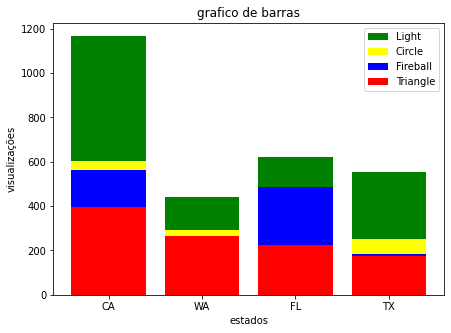

In [ ]:
#gerando o grafico de barras
Light  = np.array((1167, 442, 623, 555))
Circle = np.array((602, 290, 463, 252))
Fireball  = np.array((562, 267, 486, 183))
Triangle  = np.array((397, 267, 225, 173))


states = ['CA','WA','FL', 'TX']

plt.figure(figsize=(7,5))

plt.bar(states, Light, color = 'green')
plt.bar(states, Circle, color = 'yellow')
plt.bar(states, Fireball, color = 'blue')
plt.bar(states, Triangle, color = 'red')

plt.xlabel('estados')
plt.ylabel('visualizações')
plt.title('grafico de barras')
plt.legend(('Light', 'Circle', 'Fireball', 'Triangle'))

plt.show()

**SEGUNDA SPRINT: MAPAS**

In [ ]:
# GERANDO CSV COM AS COORDENADAS DE CADA CIDADE

csv_columns = ['ID', 'cidade', 'estado', 'lat', 'long']
csvfile = 'coords.csv'
coords = []

for i in ovnis:
  try:
    lat = zipcodes.filter_by(city=ovnis[i]['cidade'], state=ovnis[i]['estado'])[0]['lat']
    lng = zipcodes.filter_by(city=ovnis[i]['cidade'], state=ovnis[i]['estado'])[0]['long']
  except IndexError:
    lat = 32.7199
    lng = -117.1805

  coord = {
    'ID': i,
    'cidade': ovnis[i]['cidade'],
    'estado': ovnis[i]['estado'],
    'lat': lat,
    'long': lng
  }
  coords.append(coord)
  print('COORDS: ', len(coords))

  if i == '1000':
    break

try:
  with open(csvfile, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for crd in coords:
      writer.writerow(crd)
except IOError:
  print("I/O error")

In [ ]:
# Gera o mapa dos Estados Unidos com suas respectivas ocorrências (1997-2017)
coords = pd.read_csv('coords.csv')

lat = coords.lat.tolist()
lng = coords['long'].tolist()

m = folium.Map(location=[37.8427887, -98.3807258], tiles='cartodbdark_matter', zoom_start=4.25)
HeatMap(list(zip(lat, lng)), overlay=False).add_to(m)
m

In [75]:
# Gera as coordenadas das cidades dos Estados Unidos e salva em csv
csv_columns = ['ID', 'cidade', 'estado', 'lat', 'long']
csvfile = 'coords_ca.csv'
coords = []

for i in ovnis:
  try:
    if ovnis[i]['estado'] == 'CA':
      lat = zipcodes.filter_by(city=ovnis[i]['cidade'], state=ovnis[i]['estado'])[0]['lat']
      lng = zipcodes.filter_by(city=ovnis[i]['cidade'], state=ovnis[i]['estado'])[0]['long']
    else:
      continue
  except IndexError:
    continue

  coord = {
    'ID': i,
    'cidade': ovnis[i]['cidade'],
    'estado': ovnis[i]['estado'],
    'lat': lat,
    'long': lng
  }
  coords.append(coord)

coords = pd.DataFrame(coords)
coords.to_csv('coords.csv')

In [70]:
# Gera as coordenadas das cidades da Califórnia e salva em csv
coords = pd.read_csv('coords.csv')
coords_ca = []
for i, row in coords.iterrows():
  if row.estado == 'CA':
    try:
      lat = row.lat
      lng = row['long']
    except IndexError:
      continue
      
    coords_ca.append({
      'ID': i,
      'cidade': row.cidade,
      'estado': row.estado,
      'lat': lat,
      'long': lng
    })
  else:
    continue

coords_ca = pd.DataFrame(coords_ca)
coords_ca.to_csv('coords_ca.csv')

In [ ]:
# Gera o mapa da Califórnia com suas respectivas ocorrências
cca = pd.read_csv('coords_ca.csv')

lati = cca.lat.tolist()
longi = cca['long'].tolist()

mapa = folium.Map(location=[37.2454668, -120.7021918], tiles='cartodbdark_matter', zoom_start=6)
HeatMap(list(zip(lati, longi)), overlay=False).add_to(mapa)
mapa